# Анализ топ 250 фильмов IMDb

В качестве домашнего задания для практики я решил распарсить сайт IMDb и собрать некоторую статистику по топ 250 фильмов.

Для начала импортируем все нужные библиотеки

In [13]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from os.path import exists

Далее нам необходимо подгрузить курсы валют, чтобы переводить бюджет фильма в доллары. Для этого я использую сервис `exchangeratesapi.io`. 

На IMDb бюджет в большинстве случаев представлен в виде символа валюты и числа. Подходящей библиотеки, которая переводила бы символ в код я не нашел (точнее нашел только одну с подходящим методом, однако она переводила символ американского доллара как ASR), поэтому я решил вручную собрать словарик из встречающихся символов. Также французские франки и немецкие марки - валюты которые были заменены на евро в 2002 году, поэтому я использовал курс, который был на момент 2002 года.

Чтобы было удобно парсить строку с бюджетом я использовал регулярку.

In [14]:
convert = {
    '£': 'GBP',
    '₹': 'INR',
    '₩': 'KRW',
    'RUR': 'RUB',
    '$': 'USD',
    '¥': 'JPY',
    '€': 'EUR',
    'FRF': 'FRF',
    'TRL': 'TRY',
    'A$': 'AUD',
    'DEM': 'DEM',
    'R$': 'BRL'
}
CURRENCY_TOKKEN = 'cce7003fc85dfce5923c0d415d3b971f'
currency = requests.get(f'http://api.exchangeratesapi.io/v1/latest?access_key={CURRENCY_TOKKEN}').json()['rates']
currency.update({'FRF': 6.55957, 'DEM': 1.95583})
currency_pattern = re.compile("^(\D*)([\d,]*)")

Следующая регулярка нужна, чтобы удобно парсить строку с длительностью фильма. На IMDb длительность выглядит как `2h 18min`

In [15]:
time_pattern = re.compile('(?:(\d*)h)?\s?(?:(\d*)min)?')

Далее наконец идет код, который собирает необходимую мне информацию по каждому фильму и добавляет ее в список. В случае если файл уже есть, то программа подгрузит его.
Если Вы хотите заново собрать данные, просто удалите `data.csv`

### ВНИМАНИЕ

В силу того, что на каждый фильм приходится делать отдельный запрос (250 фильмов), то данный блок работает в среднем 10 мин. Локально все было проверено, он не зависает.

In [16]:
FILM_URL = r"https://www.imdb.com"
TOP_URL = "https://www.imdb.com/chart/top/?ref_=nv_mv_250"

if not exists(globals()['_dh'][0] + "/data.csv"):
    films_list = []

    ans = requests.get(TOP_URL)
    bs = BeautifulSoup(ans.content, 'html.parser')

    for film in bs.find_all('td', 'titleColumn'):
        film_info = dict()
        # Get film title
        film_info['title'] = film.a.text
        # Get film page on IMDb
        film_page = BeautifulSoup(requests.get(FILM_URL + film.a['href']).content, 'html.parser')
        # Get year
        info_list = film_page.find('ul', 'TitleBlockMetaData__MetaDataList-sc-12ein40-0').children
        film_info['year'] = int(next(info_list).span.text)
        # Get film runtime
        m = time_pattern.match(film_page.find('li', {'data-testid': 'title-techspec_runtime'}).div.text)
        hours = int(m.group(1) if m.group(1) else 0)
        minutes = int(m.group(2) if m.group(2) else 0)
        film_info['runtime'] = hours * 60 + minutes
        # Get film genres
        film_info['genres'] = {genre.span.text for genre in film_page.find_all('a', 'GenresAndPlot__GenreChip-cum89p-3')}
        # Get film rate
        film_info['rate'] = float(film_page.find('span', 'AggregateRatingButton__RatingScore-sc-1ll29m0-1').text)
        # Get director and actors
        peoples = film_page.find('div', 'PrincipalCredits__PrincipalCreditsPanelWideScreen-hdn81t-0').ul.children
        film_info['director'] = next(peoples).ul.li.a.text
        next(peoples)
        actors = next(peoples)
        if actors is not None:
            film_info['actors'] = {i.text.removesuffix('voice').strip() for i in actors.div.ul.children}
        # Get film budget
        budget = film_page.find('li', 'BoxOffice__MetaDataListItemBoxOffice-sc-40s2pl-2')
        if budget is not None:
            m = currency_pattern.match(film_page.find('li', 'BoxOffice__MetaDataListItemBoxOffice-sc-40s2pl-2').div.text)
            code = convert[m.group(1).strip()]
            money = int(m.group(2).strip().replace(',', ''))
            if code != 'USD':
                money = int(money / currency[code] * currency['USD'])
            film_info['budget'] = money
        # Get country
        film_info['countries'] = {country.text for country in film_page.find('li', {'data-testid': 'title-details-origin'}).div.ul.children}
        # Add film to film list
        films_list.append(film_info)

    films = pd.DataFrame(
        films_list,
        columns=[
            'title',
            'rate',
            'year',
            'runtime',
            'budget',
            'genres',
            'director',
            'actors',
            'countries'
        ]
    )
else:
    films = pd.read_csv(globals()['_dh'][0] + '/data.csv', converters={'genres': eval, 'countries': eval, 'actors': eval})

#### Обозначения
1. **title** - название фильма (оно нигде далее неиспользуется, но пусть будет)
2. **rate** - рейтинг фильма на IMDb
3. **year** - год выхода фильма
4. **runtime** - длительность фильма в минутах
5. **budget** - бюджет фильма в долларах
6. **genres** - множество жанров данного фильма
7. **director** - режиссер фильма
8. **actors** - 3 самых популярных актеров в данном фильме
9. **countries** - страны участвовавшие в производстве фильма

In [17]:
films

,Unnamed: 0,title,rate,year,runtime,budget,genres,director,actors,countries
0,0,Побег из Шоушенка,9.3,1994,142,25000000.0,{Drama},Frank Darabont,"{Bob Gunton, Morgan Freeman, Tim Robbins}",{United States}
1,1,Крёстный отец,9.2,1972,175,6000000.0,"{Crime, Drama}",Francis Ford Coppola,"{James Caan, Marlon Brando, Al Pacino}",{United States}
2,2,Крёстный отец 2,9.0,1974,202,13000000.0,"{Crime, Drama}",Francis Ford Coppola,"{Robert De Niro, Al Pacino, Robert Duvall}",{United States}
3,3,Темный рыцарь,9.0,2008,152,185000000.0,"{Action, Crime, Drama}",Christopher Nolan,"{Christian Bale, Heath Ledger, Aaron Eckhart}","{United States, United Kingdom}"
4,4,12 рaзгневанных мужчин,9.0,1957,96,350000.0,"{Crime, Drama}",Sidney Lumet,"{Lee J. Cobb, Martin Balsam, Henry Fonda}",{United States}
...,...,...,...,...,...,...,...,...,...,...
245,245,Принцесса-невеста,8.1,1987,98,16000000.0,"{Adventure, Family, Fantasy}",Rob Reiner,"{Robin Wright, Mandy Patinkin, Cary Elwes}","{United States, United Kingdom}"
246,246,Фанни и Александр,8.1,1982,188,6000000.0,{Drama},Ingmar Bergman,"{Bertil Guve, Pernilla Allwin, Kristina Adolph...","{West Germany, France, Sweden}"
247,247,Душа,8.1,2020,100,119253954.0,"{Comedy, Adventure, Animation}",Pete Docter,"{Jamie Foxx(voice), Graham Norton(voice), Tina...",{United States}
248,248,Ночи Кабирии,8.1,1957,110,752045.0,{Drama},Federico Fellini,"{Giulietta Masina, François Périer, Franca Marzi}","{Italy, France}"


Далее вы можете видеть 13 графиков с помошью которых я пытался найти зависимость между какими-то показателями

Первый это количество фильмов по каждому жанру. Как и следовало ожидать Драма на первом месте.

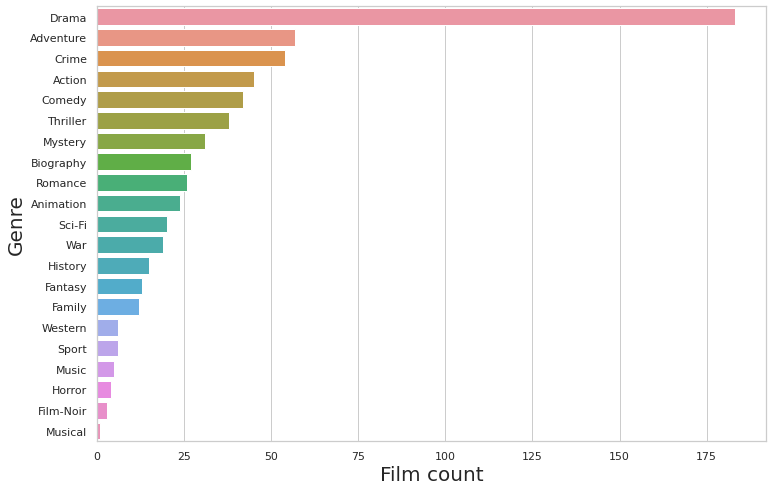

In [18]:
count_genres = dict()
for genres in films['genres']:
    for genre in genres:
        if genre in count_genres:
            count_genres[genre] += 1
        else:
            count_genres[genre] = 1

genres_list = []
for key, value in count_genres.items():
    genres_list.append({'genre': key, 'count': value})

genres_df = pd.DataFrame(genres_list, columns=['genre', 'count']).sort_values(['count'], ascending=False)

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize = ( 12 , 8 ))
sns.barplot(ax=ax, x='count', y='genre', data=genres_df)
ax.set_xlabel('Film count', size=20)
ax.set_ylabel('Genre', size=20)
plt.show()

Здесь средняя длительность по каждому жанру.

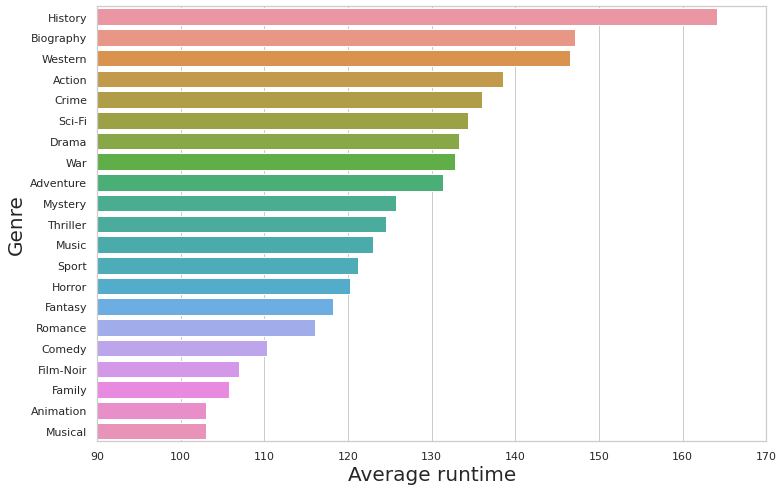

In [19]:
genre_runtime = []
for genre in genres_df['genre']:
    genre_runtime.append({'genre': genre, 'avg_runtime': round(films[pd.Series([genre in i for i in films['genres']])]['runtime'].mean(), 1)})

fig, ax = plt.subplots(figsize=(12 , 8))
sns.barplot(ax=ax, x='avg_runtime', y='genre', data=pd.DataFrame(genre_runtime, columns=['genre', 'avg_runtime']).sort_values(['avg_runtime'], ascending=False))
ax.set_xlabel('Average runtime', size=20)
ax.set_ylabel('Genre', size=20)
plt.xlim(90, 170)
plt.show()

Здесь средний бюджет по каждому жанру

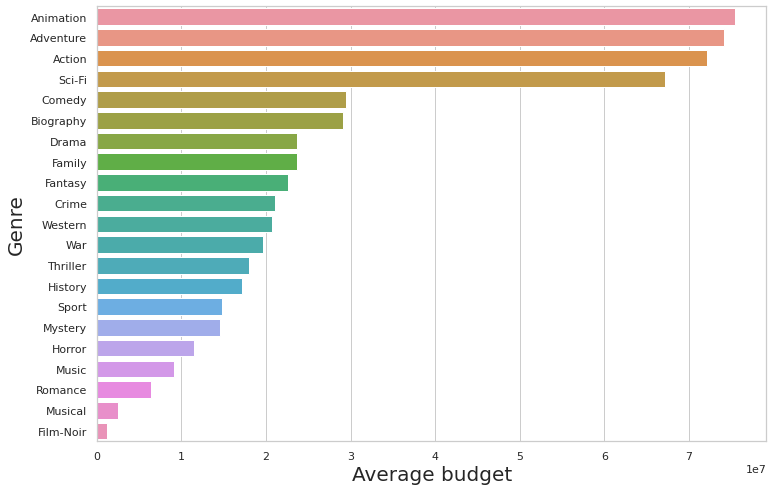

In [20]:
genre_budget = []
for genre in genres_df['genre']:
    genre_budget.append({'genre': genre, 'avg_budget': round(films[pd.Series([genre in i for i in films['genres']])]['budget'].mean(), 1)})

fig, ax = plt.subplots(figsize=(12 , 8))
sns.barplot(ax=ax, x='avg_budget', y='genre', data=pd.DataFrame(genre_budget, columns=['genre', 'avg_budget']).sort_values(['avg_budget'], ascending=False))
ax.set_xlabel('Average budget', size=20)
ax.set_ylabel('Genre', size=20)
plt.show()

Далее средний бюджет по каждому рейтингу. Как можно видеть особой зависимости рейтинга от бюджета нет (это касается только топ 250 фильмов).

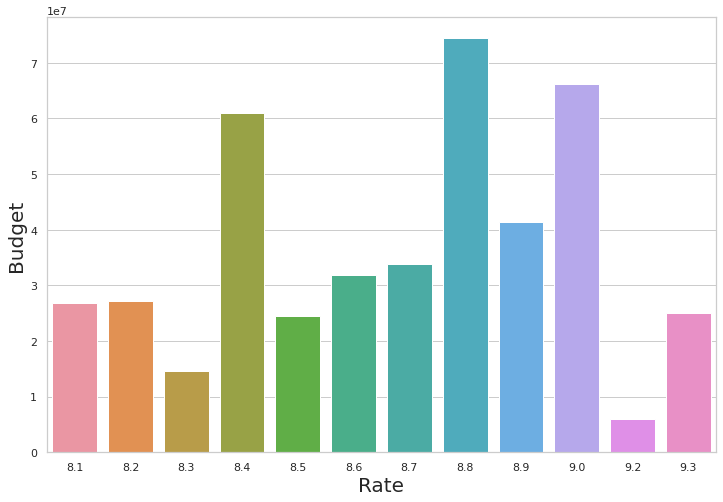

In [21]:
fig, ax = plt.subplots(figsize = ( 12 , 8 ))
sns.barplot(ax=ax, x='rate', y='budget', data=films, ci=None)
ax.set_xlabel('Rate', size=20)
ax.set_ylabel('Budget', size=20)
plt.show()

Далее можем видеть зависимость бюджета от года. Для большинства фильмов бюджет особо не поменялся, однако чем дальше, тем выше поднимается планка

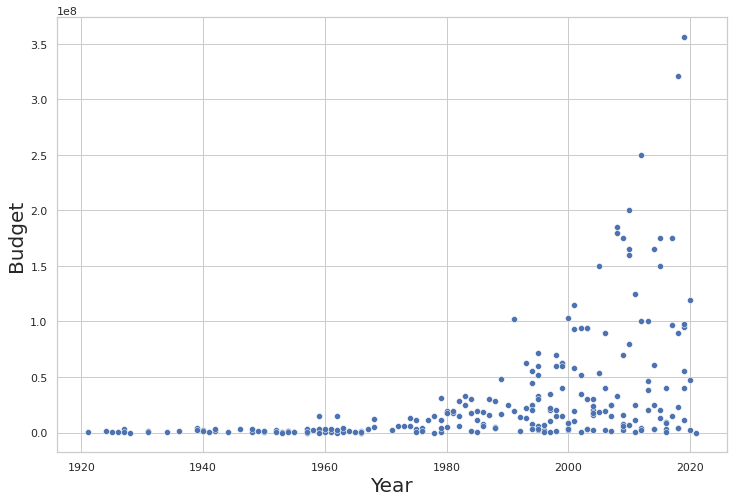

In [22]:
fig, ax = plt.subplots(figsize = ( 12 , 8 ))
sns.scatterplot(ax=ax, x='year', y='budget', data=films)
ax.set_xlabel('Year', size=20)
ax.set_ylabel('Budget', size=20)
plt.show()

Далее можем видеть режиссеров, у которых в топе наибольшее число фильмов. (На графике я оствил только тех, у которых более 2 фильмов)

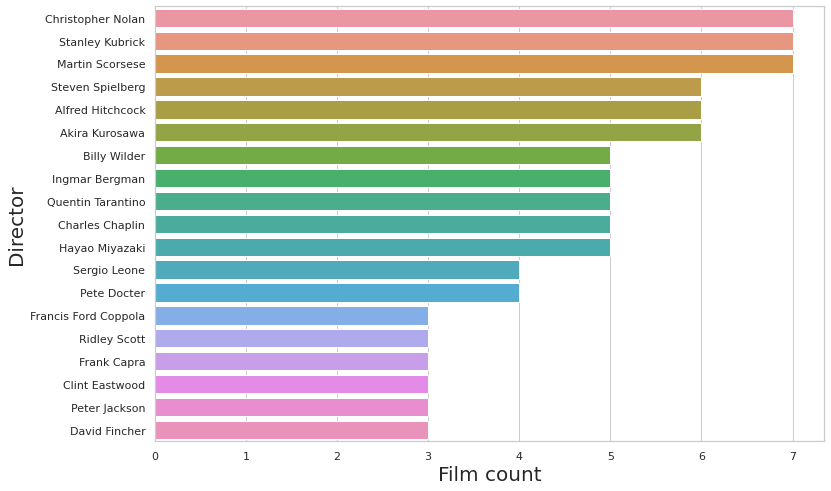

In [23]:
director_count = films['director'].value_counts().rename_axis('director').reset_index(name='count')
director_count = director_count[director_count['count'] > 2]
fig, ax = plt.subplots(figsize = ( 12 , 8 ))
sns.barplot(ax=ax, x='count', y='director', data=director_count)
ax.set_xlabel('Film count', size=20)
ax.set_ylabel('Director', size=20)
plt.show()

Теперь по тому же списку режиссеров оценим средний рейтинг их фильмов

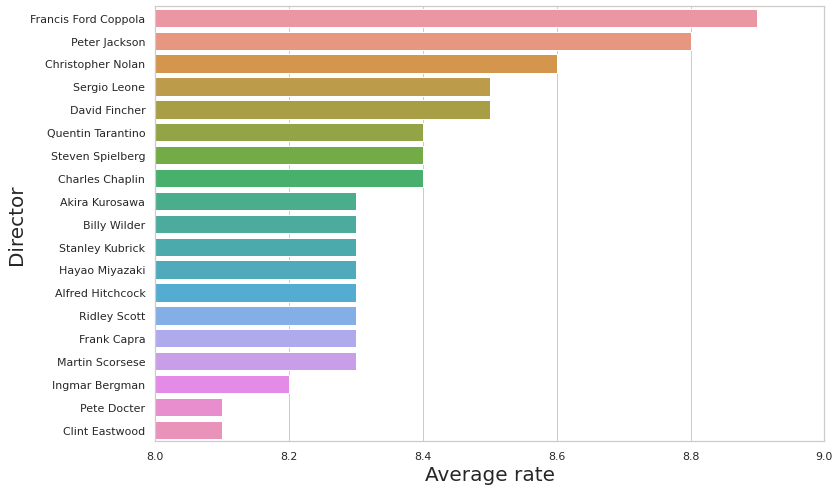

In [24]:
director_rate = []
for director in director_count['director']:
    director_rate.append({'director': director, 'avg_rate': round(films[films['director'] == director]['rate'].mean(), 1)})

fig, ax = plt.subplots(figsize=(12 , 8))
sns.barplot(ax=ax, x='avg_rate', y='director', data=pd.DataFrame(director_rate, columns=['director', 'avg_rate']).sort_values(['avg_rate'], ascending=False))
ax.set_xlabel('Average rate', size=20)
ax.set_ylabel('Director', size=20)
plt.xlim(8, 9)
plt.show()

И также оценим средний бюджет. Что странно, то у режиссера с практически самым низким средним рейтингом, самый высокий средний бюджет

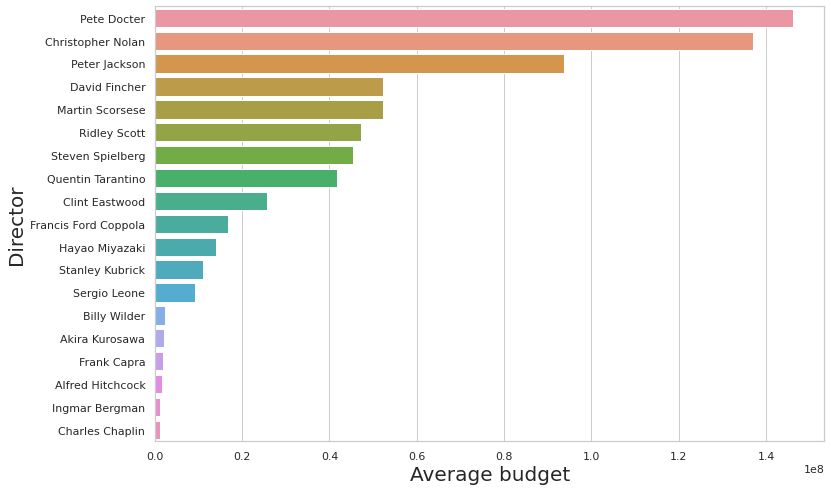

In [25]:
director_budget = []
for director in director_count['director']:
    director_budget.append({'director': director, 'avg_budget': round(films[films['director'] == director]['budget'].mean(), 1)})

fig, ax = plt.subplots(figsize=(12 , 8))
sns.barplot(ax=ax, x='avg_budget', y='director', data=pd.DataFrame(director_budget, columns=['director', 'avg_budget']).sort_values(['avg_budget'], ascending=False))
ax.set_xlabel('Average budget', size=20)
ax.set_ylabel('Director', size=20)
plt.show()

Теперь проведем такой же анализ по актерам. Сначала количество фильмов у актеров (Здесь наложим такое же условие как и для режиссеров)

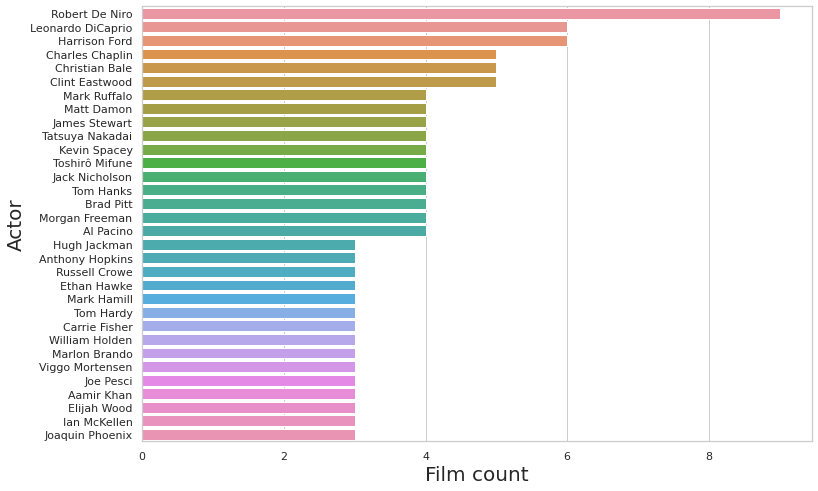

In [26]:
count_actors = dict()
for actors in films['actors']:
    for actor in actors:
        if actor in count_actors:
            count_actors[actor] += 1
        else:
            count_actors[actor] = 1

actors_list = []
for key, value in count_actors.items():
    actors_list.append({'actor': key, 'count': value})

actors_df = pd.DataFrame(actors_list, columns=['actor', 'count']).sort_values(['count'], ascending=False)
actors_df = actors_df[actors_df['count'] > 2]

fig, ax = plt.subplots(figsize = ( 12 , 8 ))
sns.barplot(ax=ax, x='count', y='actor', data=actors_df)
ax.set_xlabel('Film count', size=20)
ax.set_ylabel('Actor', size=20)
plt.show()

Теперь посмотрим на средний рейтинг

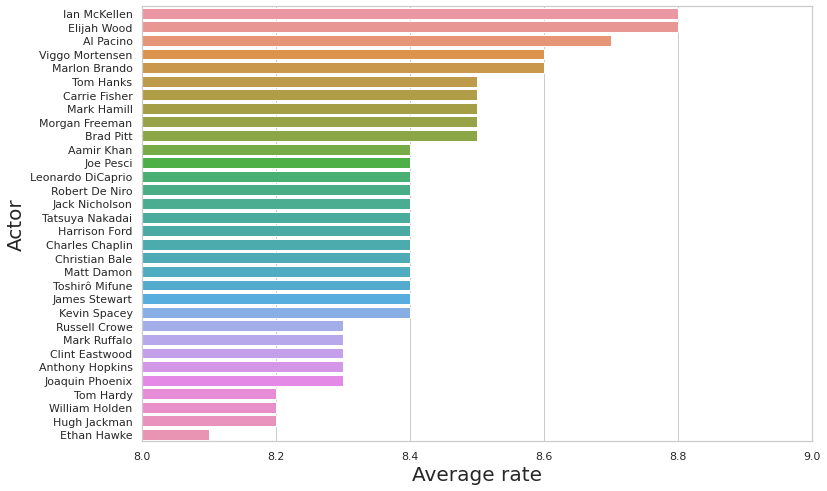

In [27]:
actor_rate = []
for actor in actors_df['actor']:
    actor_rate.append({'actor': actor, 'avg_rate': round(films[pd.Series([actor in i for i in films['actors']])]['rate'].mean(), 1)})

fig, ax = plt.subplots(figsize=(12 , 8))
sns.barplot(ax=ax, x='avg_rate', y='actor', data=pd.DataFrame(actor_rate, columns=['actor', 'avg_rate']).sort_values(['avg_rate'], ascending=False))
ax.set_xlabel('Average rate', size=20)
ax.set_ylabel('Actor', size=20)
plt.xlim(8, 9)
plt.show()

И на средний бюджет

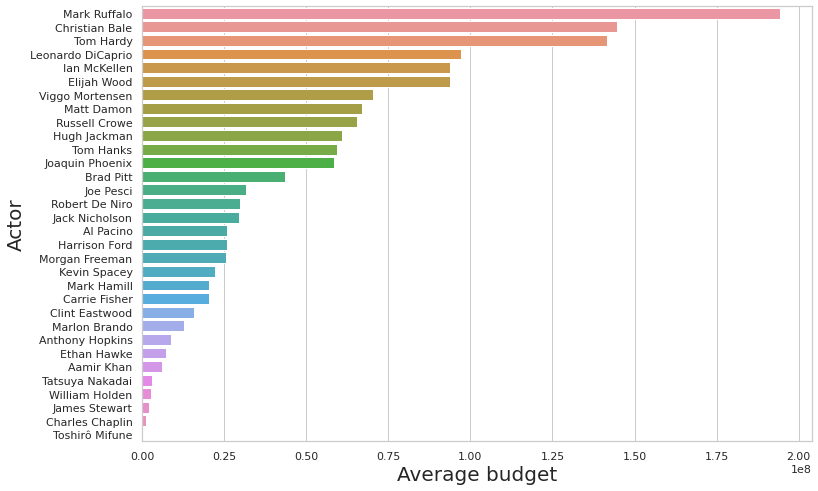

In [28]:
actor_budget = []
for actor in actors_df['actor']:
    actor_budget.append({'actor': actor, 'avg_budget': round(films[pd.Series([actor in i for i in films['actors']])]['budget'].mean(), 1)})

fig, ax = plt.subplots(figsize=(12 , 8))
sns.barplot(ax=ax, x='avg_budget', y='actor', data=pd.DataFrame(actor_budget, columns=['actor', 'avg_budget']).sort_values(['avg_budget'], ascending=False))
ax.set_xlabel('Average budget', size=20)
ax.set_ylabel('Actor', size=20)
plt.show()

Теперь оценим количество фильмов у каждой страны. Как и следовало ожидать лидирует США (Смотрим только на те страны у которых более 4 фильмов)

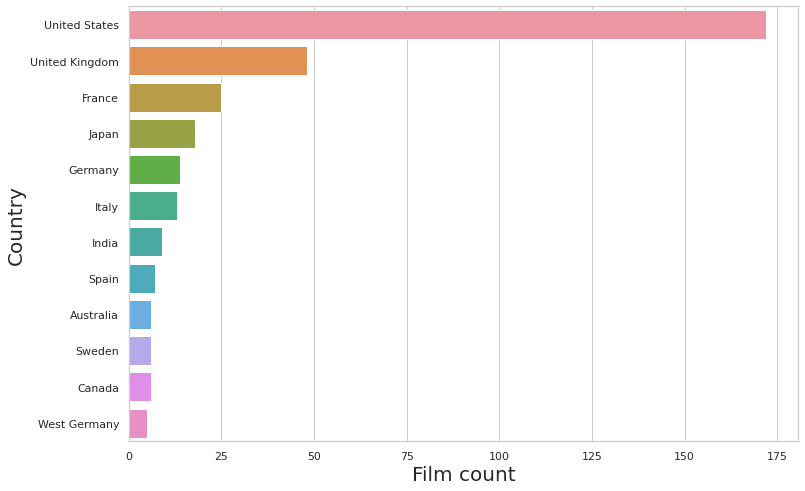

In [29]:
count_countries = dict()
for countries in films['countries']:
    for country in countries:
        if country in count_countries:
            count_countries[country] += 1
        else:
            count_countries[country] = 1

countries_list = []
for key, value in count_countries.items():
    countries_list.append({'country': key, 'count': value})

countries_df = pd.DataFrame(countries_list, columns=['country', 'count']).sort_values(['count'], ascending=False)
countries_df = countries_df[countries_df['count'] > 4]

fig, ax = plt.subplots(figsize = ( 12 , 8 ))
sns.barplot(ax=ax, x='count', y='country', data=countries_df)
ax.set_xlabel('Film count', size=20)
ax.set_ylabel('Country', size=20)
plt.show()

Теперь взглянем на средний бюджет по стране. Как мы видим некоторое число фильмов США с не очень большим бюджетом оказало соотвествующий эффект

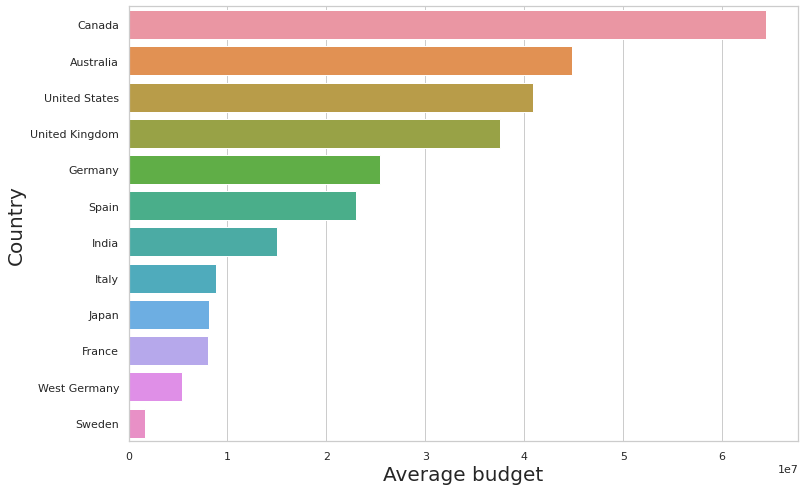

In [30]:
country_budget = []
for country in countries_df['country']:
    country_budget.append({'country': country, 'avg_budget': round(films[pd.Series([country in i for i in films['countries']])]['budget'].mean(), 1)})

fig, ax = plt.subplots(figsize=(12 , 8))
sns.barplot(ax=ax, x='avg_budget', y='country', data=pd.DataFrame(country_budget, columns=['country', 'avg_budget']).sort_values(['avg_budget'], ascending=False))
ax.set_xlabel('Average budget', size=20)
ax.set_ylabel('Country', size=20)
plt.show()

На этом все. Возможно представленный мной анализ не очень информативный, однако его можно использовать как нечто интересное и занимательное. Например посмотреть сравнение своих любимых актеров.